In [1]:
from sklearn.cluster import AgglomerativeClustering
from _jsonnet import evaluate_file as jsonnet_evaluate_file
import json
from transformers import EncoderDecoderModel, logging, BertTokenizer

from models.bottleneck_encoder_decoder import BottleneckEncoderDecoderModel
from utils.clustering_utils import calc_clustering_metrics, get_text_to_vector_func

logging.set_verbosity_info()

import matplotlib.pyplot as plt

**Parameters**

In [2]:
config = json.loads(jsonnet_evaluate_file('../configs/style_gen_title_from_scratch.jsonnet'))

max_tokens_text = config.pop('max_tokens_text')
max_tokens_title = config.pop('max_tokens_title')
text_to_vec_func = 'bert-FirstCLS'

In [3]:
agency_list = ["ТАСС", "RT на русском", "РБК"]

### Load model & tokenizer

In [4]:
model_path = '/home/aobuhtijarov/models/tg_gen_title_bottleneck/checkpoint-6000/'
gold_markup_file = '/home/aobuhtijarov/datasets/telegram_news/ru_clustering_0517.tsv'
clustering_data = '/home/aobuhtijarov/datasets/telegram_news/ru_clustering_data.jsonl'
tokenizer_model_path = '/home/aobuhtijarov/models/rubert_cased_L-12_H-768_A-12_pt'
train_data = '/home/aobuhtijarov/datasets/telegram_news/ru_tg_1101_0510.jsonl'
test_data = '/home/aobuhtijarov/datasets/telegram_news/ru_tg_0511_0517.jsonl'

In [5]:
tokenizer = BertTokenizer.from_pretrained(tokenizer_model_path, do_lower_case=False, do_basic_tokenize=False)
setattr(tokenizer, 'max_tokens_text', max_tokens_text)

Didn't find file /home/aobuhtijarov/models/rubert_cased_L-12_H-768_A-12_pt/added_tokens.json. We won't load it.
Didn't find file /home/aobuhtijarov/models/rubert_cased_L-12_H-768_A-12_pt/special_tokens_map.json. We won't load it.
Didn't find file /home/aobuhtijarov/models/rubert_cased_L-12_H-768_A-12_pt/tokenizer_config.json. We won't load it.
Didn't find file /home/aobuhtijarov/models/rubert_cased_L-12_H-768_A-12_pt/tokenizer.json. We won't load it.
loading file /home/aobuhtijarov/models/rubert_cased_L-12_H-768_A-12_pt/vocab.txt
loading file None
loading file None
loading file None
loading file None


In [6]:
from utils.clustering_utils import get_text_to_vector_func
from utils.clusterer import Clusterer
import tqdm
from readers.tg_reader import tg_reader

In [7]:
records = [r for r in tqdm.tqdm(tg_reader(train_data))]

484037it [04:33, 1772.95it/s]


In [8]:
lenta_records = [r for r in records if r['agency'] == 'lenta.ru']

In [10]:
set([x['date'].split()[0] for x in lenta_records ])

{'2019-11-01',
 '2019-11-02',
 '2019-11-03',
 '2019-11-04',
 '2019-11-05',
 '2019-11-06',
 '2019-11-07',
 '2019-11-08',
 '2019-11-09',
 '2019-11-10',
 '2019-11-11',
 '2019-11-12',
 '2019-11-13',
 '2019-11-14',
 '2019-11-15',
 '2019-11-16',
 '2019-11-17',
 '2019-11-18',
 '2019-11-19',
 '2019-11-20',
 '2019-11-21',
 '2019-11-22',
 '2019-11-23',
 '2019-11-24',
 '2019-11-25',
 '2019-11-29',
 '2019-12-09',
 '2020-04-27',
 '2020-04-28',
 '2020-04-29',
 '2020-04-30',
 '2020-05-01',
 '2020-05-02',
 '2020-05-03',
 '2020-05-04',
 '2020-05-05',
 '2020-05-06',
 '2020-05-07',
 '2020-05-08',
 '2020-05-09',
 '2020-05-10'}

In [27]:
test_records = [r for r in tqdm.tqdm(tg_reader(test_data))]

119922it [01:29, 1346.86it/s]


In [10]:
from collections import defaultdict

agency_to_titles = defaultdict(list)

for r in records:
    agency_to_titles[r['agency']].append(r['title'])

In [30]:
test_agency_to_titles = defaultdict(list)

for r in test_records:
    test_agency_to_titles[r['agency']].append(r['title'])

In [31]:
res = [(k, len(v)) for k, v in agency_to_titles.items()]
test_res = [(k, len(v)) for k, v in test_agency_to_titles.items()]

In [32]:
res.sort(key=lambda x: -x[1])
test_res.sort(key=lambda x: -x[1])

In [50]:
[x.replace('\xa0', ' ').replace('\n', ' ').strip() for x in test_agency_to_titles['lenta.ru'][:22]]

['бросивший гранату в толпу россиянин объяснился',
 'тактаров оценил шансы нурмагомедова в поединке с гэтжи',
 'два человека погибли в результате пожара в российском хосписе',
 'в российском регионе отменят пропуска для выхода из дома',
 'авиакомпании ужесточат правила посадки на вывозные рейсы для россиян',
 'в российском городе загорелся хоспис',
 'стало известно об отсутствии документов у сгоревшего в подмосковье хосписа',
 'фармацевтический гигант выпустит до миллиарда доз вакцины от коронавируса',
 'опубликовано видео с места пожара в подмосковном хосписе',
 'число погибших в сгоревшем российском хосписе выросло',
 'количество погибших при пожаре в хосписе возросло до десяти',
 'девять человек погибли в пожаре в подмосковном хосписе',
 'в столичной квартире нашли тела пенсионерки и ее сына-инвалида',
 'россиян предупредили о резком похолодании',
 'иранские военные по ошибке обстреляли свой же корабль и убили весь его экипаж',
 'еврокомиссия задумалась о санкциях для германии',
 'с

In [48]:
test_agency_to_titles['RT на русском'][:22]

['землетрясение магнитудой 5,5 зафиксировано в чили',
 'вильфанд предупредил о резком похолодании в европейской части россии',
 'число случаев заболевания коронавирусом в канаде достигло 68 848',
 'в китае за сутки не выявлено смертей от коронавируса',
 'авиакомпании усилят проверку пассажиров вывозных рейсов',
 'число инфицированных коронавирусом в мексике превысило 35 тысяч',
 'в мвд назвали регионы — лидеры по числу нарушений режима самоизоляции',
 'в минобороны прокомментировали возвращение специалистов из италии',
 'число заболевших коронавирусом в приморье превысило 900',
 'землетрясение магнитудой 5,8 произошло у побережья японии',
 'число заболевших коронавирусом в германии составило 169 575',
 'в москве 11 мая ожидается до +20 °с',
 'ек выделит до €15,8 млн на «улучшение мнения» о ес в соседних странах',
 '«наглядный пример непорядочности»: как китай опроверг обвинения сша в распространении covid-19',
 'число инфицированных коронавирусом в казахстане достигло 5126',
 'в южной 

In [49]:
test_agency_to_titles['ТАСС'][:22]

['источник: испытания новой гиперзвуковой ракеты прошли с борта ту-22м3',
 'в чили произошло землетрясение',
 'в японии произошло землетрясение',
 'коллекторы считают, что 40% сотрудников компаний могут просрочить платежи по кредитам',
 'пожар в хосписе в красногорске. главное',
 'каннский кинофестиваль не будут проводить в 2020 году',
 'у берегов индонезии произошло землетрясение',
 'чемпионат испании по футболу может возобновиться 12 июня',
 'в красноярске потушили пожар на продовольственном складе',
 'роспотребнадзор дал рекомендации по онлайн-покупкам в условиях пандемии',
 'в бурятии за сутки потушили лесные пожары на площади более 3,8 тыс. га',
 'четыре человека погибли при пожаре в дачном домике в тувинском поселке',
 'в мчс создали систему управления подразделениями беспилотной авиации',
 'в приморье за сутки зафиксировали более 50 случаев заражения коронавирусной инфекцией',
 'сми: в иране на учениях произошел инцидент с ракетным катером',
 'более 40 военнослужащих рф, задейст

In [35]:
{x for x in res if 'lenta' in x[0].lower() or 'лента' in x[0].lower()}

{('iLenta', 284), ('lenta.ru', 3165)}

In [36]:
test_res

[('ТАСС', 3989),
 ('lenta.ru', 1608),
 ('www.mk.ru', 1394),
 ('RT на русском', 1263),
 ('РИАМО', 1229),
 ('Dynamomania.com', 1068),
 ('Росбалт', 1013),
 ('Новости Мойка78', 976),
 ('Телеграф', 944),
 ('Новости Украины - From-UA', 920),
 ('URA.RU', 903),
 ('ALLSPORT-NEWS', 885),
 ('ФедералПресс', 878),
 ('Известия', 870),
 ('strana.ua', 866),
 ('Корреспондент.net', 845),
 ('РИА Мелитополь', 826),
 ('Парламентская Газета', 798),
 ('Апостроф', 784),
 ('vesti.ru', 780),
 ('ПРАЙМ', 777),
 ('Вестник Кавказа', 765),
 ('Глас Народа', 763),
 ('СПОРТ.UA', 752),
 ('RuNews24', 752),
 ('Правда.Ру', 749),
 ('zakon.kz', 730),
 ('EADaily', 706),
 ('Коммерсантъ', 705),
 ('charter97.org', 701),
 ('Интерфакс-Украина', 698),
 ('Рамблер/новости', 683),
 ('Народные Новости России', 674),
 ('Реальное время', 662),
 ('Znak', 645),
 ('ПолитЭксперт', 644),
 ('ФБА «Экономика сегодня»', 644),
 ('Gordonua', 641),
 ('РБК', 640),
 ('Интерфакс', 633),
 ('Нью Информ', 630),
 ('Инфореактор', 623),
 ('Главное™', 614),
 

In [14]:
res

[('Невские Новости', 6563),
 ('RT на русском', 5256),
 ('Корреспондент.net', 5200),
 ('ФедералПресс', 4975),
 ('ТАСС', 4532),
 ('Регион Online', 4450),
 ('Известия', 4375),
 ('РИАМО', 4305),
 ('НВ', 4054),
 ('Новости Мойка78', 3939),
 ('Коммерсантъ', 3858),
 ('EADaily', 3752),
 ('Росбалт', 3719),
 ('РИА Мелитополь', 3522),
 ('RuNews24', 3448),
 ('Dynamomania.com', 3273),
 ('Главное™', 3247),
 ('charter97.org', 3247),
 ('lenta.ru', 3165),
 ('URA.RU', 3157),
 ('Українські Новини', 3072),
 ('ALLSPORT-NEWS', 3048),
 ('Телеграф', 3045),
 ('СПОРТ.UA', 2925),
 ('Новости Украины - From-UA', 2920),
 ('Новый День', 2914),
 ('Народные Новости России', 2885),
 ('РИА Новости', 2885),
 ('Interfax.ru', 2867),
 ('Накануне.ru', 2843),
 ('Глас Народа', 2773),
 ('Интерфакс-Украина', 2701),
 ('РБК', 2661),
 ('strana.ua', 2636),
 ('www.mk.ru', 2618),
 ('Рамблер/новости', 2613),
 ('Вестник Кавказа', 2557),
 ('Апостроф', 2550),
 ('ФБА «Экономика сегодня»', 2539),
 ('Парламентская Газета', 2522),
 ('Фонтанка.

In [40]:
from custom_datasets.gen_title_dataset import GenTitleDataset

test_dataset = GenTitleDataset(
    test_records,
    tokenizer,
    max_tokens_text=200,
    max_tokens_title=40
)

In [41]:
all_dates = {test_dataset.get_strings(i)['date'].split(' ')[0] for i in range(len(test_dataset))}

In [42]:
all_dates

{'2020-05-11',
 '2020-05-12',
 '2020-05-13',
 '2020-05-14',
 '2020-05-15',
 '2020-05-16',
 '2020-05-17',
 '2020-05-18'}

In [43]:
clusterer = Clusterer(
    get_text_to_vector_func(
        'bert-FirstCLS',
        BottleneckEncoderDecoderModel.from_pretrained(model_path),
        tokenizer),
    test_dataset,
    0.18,
)

loading configuration file /home/aobuhtijarov/models/tg_gen_title_bottleneck/checkpoint-6000/config.json
Model config EncoderDecoderConfig {
  "architectures": [
    "BottleneckEncoderDecoderModel"
  ],
  "decoder": {
    "_name_or_path": "/home/aobuhtijarov/models/pretrained_dec_6_layers",
    "add_cross_attention": true,
    "architectures": [
      "BertModel"
    ],
    "attention_probs_dropout_prob": 0.2,
    "bad_words_ids": null,
    "bos_token_id": null,
    "chunk_size_feed_forward": 0,
    "decoder_start_token_id": null,
    "directionality": "bidi",
    "diversity_penalty": 0.0,
    "do_sample": false,
    "early_stopping": false,
    "encoder_no_repeat_ngram_size": 0,
    "eos_token_id": null,
    "finetuning_task": null,
    "forced_bos_token_id": null,
    "forced_eos_token_id": null,
    "gradient_checkpointing": false,
    "hidden_act": "gelu",
    "hidden_dropout_prob": 0.2,
    "hidden_size": 768,
    "id2label": {
      "0": "LABEL_0",
      "1": "LABEL_1"
    },
   

In [44]:
clusterer.perform_clustering()

filling graph: 100%|██████████| 20744/20744 [00:50<00:00, 410.72it/s] 


In [49]:
lens = [ len(list(clusterer.get_cluster_records(i))) for i in range(len(test_dataset))]


In [55]:
[x for x in lens if x > 1]

[196,
 11,
 16,
 3,
 3,
 6,
 26,
 25,
 8,
 196,
 2,
 2,
 2,
 2,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 33,
 2,
 9,
 10,
 2,
 60,
 3,
 14,
 9,
 15,
 4,
 17,
 7,
 7,
 75,
 6,
 250,
 11,
 2,
 7,
 2,
 2,
 2,
 2,
 2,
 2,
 10,
 26,
 196,
 5,
 2,
 2,
 3,
 33,
 25,
 6,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 21,
 2,
 17,
 5,
 6,
 2,
 3,
 9,
 5,
 4,
 9,
 4,
 6,
 28,
 5,
 21,
 3,
 4,
 2,
 3,
 2,
 10,
 250,
 75,
 196,
 2,
 70,
 3,
 250,
 7,
 2,
 3,
 4,
 3,
 2,
 5,
 3,
 196,
 75,
 6,
 2,
 5,
 75,
 19,
 9,
 9,
 196,
 2,
 4,
 3,
 2,
 3,
 13,
 6,
 7,
 7,
 2,
 4,
 5,
 3,
 3,
 4,
 2,
 6,
 3,
 8,
 5,
 4,
 5,
 2,
 3,
 2,
 12,
 6,
 15,
 3,
 2,
 4,
 3,
 5,
 7,
 3,
 7,
 9,
 68,
 13,
 3,
 2,
 4,
 3,
 24,
 2,
 15,
 15,
 15,
 3,
 10,
 4,
 2,
 2,
 2,
 2,
 7,
 2,
 3,
 43,
 38,
 8,
 4,
 5,
 2,
 2,
 2,
 2,
 4,
 13,
 9,
 68,
 4,
 196,
 23,
 2,
 3,
 12,
 8,
 2,
 6,
 4,
 3,
 3,
 2,
 3,
 75,
 17,
 25,
 21,
 3,
 9,
 2,
 27,
 2,
 3,
 14,
 27,
 5,
 3,
 5,
 75,
 4,
 28,
 3,
 3,
 196,
 20,
 4,
 2,
 38,
 13,
 17,
 43,
 250,
 4,
 10,

(array([10057.,   708.,    75.,   143.,     0.,   196.,   250.,     0.,
            0.,   362.]),
 array([  2.,  38.,  74., 110., 146., 182., 218., 254., 290., 326., 362.]),
 <BarContainer object of 10 artists>)

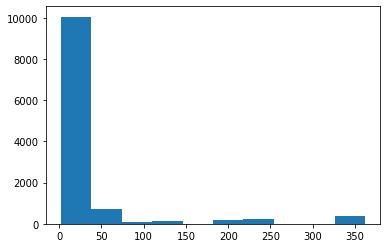

In [54]:
plt.hist()

### Prepare train dataset

In [8]:
from custom_datasets.agency_title_dataset import AgencyTitleDataset
from readers.tg_reader import tg_reader
import tqdm
import random
import numpy as np

In [9]:
train_records = [r for r in tqdm.tqdm(tg_reader(train_file, agency_list))]

18032it [04:23, 68.36it/s] 


In [10]:
text_to_vector_func = get_text_to_vector_func(text_to_vec_func, model, tokenizer)

In [11]:
train_dataset = AgencyTitleDataset(
    train_records,
    tokenizer,
    agency_list,
    max_tokens_text=max_tokens_text,
    max_tokens_title=max_tokens_title
)

In [20]:
total_articles = len(train_dataset)
print('Number of articles in the dataset:', total_articles)

Number of articles in the dataset: 18032


In [13]:
train_embeds = np.empty((total_articles, 768))

for i in tqdm.trange(total_articles):
    record = train_dataset.get_strings(i)
    text = record["title"] + ' ' + record["text"]
    text = text.lower().replace('\xa0', ' ')
    train_embeds[i] = text_to_vector_func(text).detach().numpy().ravel()

100%|██████████| 18032/18032 [27:20<00:00, 10.99it/s]


### Fitting AgglomerativeClustering

In [14]:
%%time

clustering_model = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=0.18,
    linkage="single",
    affinity="cosine"
)

clustering_model.fit(train_embeds)
train_labels = clustering_model.labels_

CPU times: user 1min 37s, sys: 815 ms, total: 1min 38s
Wall time: 1min 38s


In [15]:
print('Number of clusters:', len(set(train_labels)))

Number of clusters: 14793


In [16]:
from collections import defaultdict

cluster_to_inds = defaultdict(list)

for i, label in enumerate(train_labels):
    cluster_to_inds[label].append(i)

In [17]:
cluster_to_inds

defaultdict(list,
            {10674: [0],
             14290: [1],
             10263: [2],
             9588: [3],
             9966: [4],
             11987: [5],
             347: [6, 3373],
             12301: [7],
             8788: [8],
             8471: [9],
             806: [10, 1559, 2065, 3069],
             13751: [11],
             148: [12, 1426, 2649, 2793, 3230, 5135, 9328, 11260, 11274],
             2604: [13, 20],
             560: [14, 3302],
             774: [15, 3174],
             11295: [16],
             9303: [17],
             1039: [18, 72, 263, 564],
             2016: [19, 2512],
             10872: [21],
             13581: [22],
             14662: [23],
             13602: [24],
             13983: [25],
             352: [26, 33, 250],
             14430: [27],
             8811: [28],
             1277: [29, 30],
             10851: [31],
             7831: [32],
             11764: [34],
             419: [35, 3246],
             440: [36,
       

In [21]:
def get_articles_summary(inds, dataset):        
    return ''.join([
        f'Agency: {dataset.get_strings(i)["agency"]}\nTitle:\n{dataset.get_strings(i)["title"]}\nText:\n{dataset.get_strings(i)["text"]}\n\n'
        for i in inds
    ])

def dump_clusters(cluster_to_inds, train_dataset):
    with open('clusters.txt', 'w', encoding='utf-8') as f:
        for cl_id in cluster_to_inds:
            f.write(f'\tCluster #{cl_id}:\n\n')
            f.write(get_articles_summary(cluster_to_inds[cl_id], train_dataset))
            f.write('\n\n' + ('-'*50+'\n') * 2 + '\n\n')

In [22]:
dump_clusters(cluster_to_inds, train_dataset)

In [26]:
print(get_articles_summary(cluster_to_inds[148], train_dataset))

Agency: RT на русском
Title:
у гуама произошло землетрясение магнитудой 5,6
Text:
землетрясение магнитудой 5,6 зафиксировано у берегов принадлежащего сша острова гуам в тихом океане. об этом сообщает геологическая служба сша (usgs). эпицентр подземных толчков находился в 41 км к северо-западу от населённого пункта йиго. очаг залегал на глубине около 67 км. данных о возможных пострадавших, разрушениях и об угрозе цунами не поступало. ранее сообщалось, что у побережья фиджи произошло землетрясение магнитудой 5,8.

Agency: ТАСС
Title:
у берегов самоа произошло землетрясение магнитудой 5,6
Text:
тасс, 6 мая. землетрясение магнитудой 5,6 произошло в тихом океане, у берегов островного государства самоа. об этом во вторник сообщила геологическая служба сша. по ее данным, эпицентр находился в 118 км к юго-западу от столицы самоа, города апиа (около 40 тыс. жителей). очаг залегал на глубине 33 км. сведений о пострадавших и разрушениях не поступало. угроза цунами не объявлялась.

Agency: RT на р

In [27]:
cluster_sizes = [len(x) for x in cluster_to_inds.values()]

In [28]:
from collections import Counter

Counter(cluster_sizes)

Counter({1: 13119,
         2: 1145,
         4: 95,
         9: 10,
         3: 288,
         22: 1,
         71: 1,
         7: 19,
         23: 1,
         8: 8,
         6: 30,
         5: 38,
         15: 2,
         16: 1,
         11: 9,
         10: 6,
         12: 4,
         18: 1,
         36: 1,
         25: 1,
         44: 1,
         27: 1,
         13: 4,
         14: 2,
         21: 1,
         32: 2,
         19: 2})

### Presumably good clusters

In [30]:
cnt = 0
for cl_id in cluster_to_inds:
    if len(cluster_to_inds[cl_id]) != len(agency_list):
        continue
        
    a = {train_dataset.get_strings(i)["agency"] for i in cluster_to_inds[cl_id]}
    if a == set(agency_list):
        cnt += 1
        print(get_articles_summary(cluster_to_inds[cl_id], train_dataset))
        print('\n\n' + ('-'*50+'\n') * 2 + '\n\n')

Agency: ТАСС
Title:
в шереметьево совершил экстренную посадку ssj-100 из-за отказа двигателя
Text:
москва, 5 мая. /тасс/. пассажирский самолет sukhoi superjet 100 совершил экстренную посадку в аэропорту шереметьево из-за отказа двигателя. об этом тасс сообщили в экстренных службах. "после вылета в саратов, по предварительным данным, у самолета отказал левый двигатель. экипаж принял решение о возвращении. в 07:16 он совершил экстренную посадку в штатном режиме", - сказал собеседник агентства. пострадавших нет. в экстренных службах уточнили, что ssj-100 вылетел в саратов около 06:45. в воздухе он пробыл около получаса, сделав несколько кругов перед посадкой. самолет будет осмотрен технической службой. причины произошедшего устанавливаются. в новость внесена правка (07:27 мск) - передается с уточнением пункта вылета, верно - саратов.

Agency: Новости Мойка78
Title:
в шереметьево приземлился самолет после отказа левого двигателя
Text:
самолет sukhoi superjet 100, который летел из саратова 

In [31]:
print('Presumably good clusters number:', cnt)

Presumably good clusters number: 9
